<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S5/eva_session5%20-%20iter%206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Iteration 6





Target
1. Using dropout to avoid any overfitting and complement the added transformations in train data
2. dropout value = 0.02 (2%)

Results
1. parameters = 6,398
2. Best Train Accuracy = 99.32
3. Best Test Accuracy = 99.46

Analysis
1. Great Model! The model performed well in last 8 epochs maintaining a greater then 99.40% for all the time.

2. Dropout helped the model to achieve steadiness.

3. The model is becomming good and can be better if pushed further. Less fluctuation in test accuracy.



---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

!pip install torchsummary
from torchsummary import summary

## Getting to know our data

In [2]:
# Downloading the dataset and setting up dataloader for visualisationn only

train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

torch.Size([64, 1, 28, 28])
torch.Size([64])




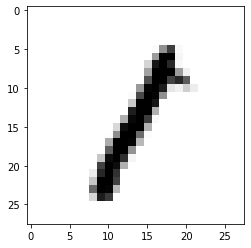

In [3]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_set.train_data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

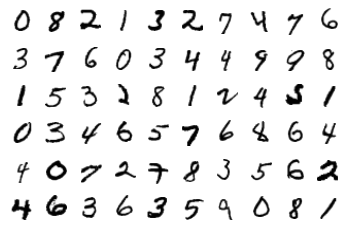

In [4]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Setting up Dataloaders and Transformations


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),    
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_set , batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


## Making our model

In [8]:
dropout_rate = 0.02

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias=False), # RF - 3x3
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # RF - 3x3
            
            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # RF - 5x5

            nn.MaxPool2d(2, 2), # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, bias=False), # RF - 12x12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # RF - 12x12

            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.Dropout(dropout_rate), # RF - 14x14

            nn.MaxPool2d(2, 2), # RF - 28x28
            
            nn.Conv2d(16, 10, 3, bias=False), # RF - 30x30
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_rate) # RF - 30x30

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 1, bias=False), # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=[-2,-1]) # GAP Layer

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [9]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
      BatchNorm2d-11           [-1, 16, 10, 10]              32
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.15)

for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH - 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.017213698476552963 Batch_id=937 Accuracy=92.69: 100%|██████████| 938/938 [00:19<00:00, 47.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9849/10000 (98%)

EPOCH - 2


Loss=0.1522100567817688 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:19<00:00, 47.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9891/10000 (99%)

EPOCH - 3


Loss=0.004258349537849426 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:19<00:00, 48.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9907/10000 (99%)

EPOCH - 4


Loss=0.0035522955004125834 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99%)

EPOCH - 5


Loss=0.0926838144659996 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:19<00:00, 48.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9906/10000 (99%)

EPOCH - 6


Loss=0.019457094371318817 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:20<00:00, 45.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99%)

EPOCH - 7


Loss=0.044326234608888626 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:19<00:00, 48.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99%)

EPOCH - 8


Loss=0.036460552364587784 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:20<00:00, 46.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99%)

EPOCH - 9


Loss=0.005096615757793188 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:19<00:00, 48.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99%)

EPOCH - 10


Loss=0.004354671109467745 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:20<00:00, 46.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99%)

EPOCH - 11


Loss=0.003962753340601921 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:19<00:00, 47.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99%)

EPOCH - 12


Loss=0.018062181770801544 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:19<00:00, 49.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99%)

EPOCH - 13


Loss=0.006663622334599495 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:19<00:00, 48.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99%)

EPOCH - 14


Loss=0.015222565270960331 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:19<00:00, 48.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9945/10000 (99%)

EPOCH - 15


Loss=0.02846595272421837 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:19<00:00, 49.07it/s]



Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

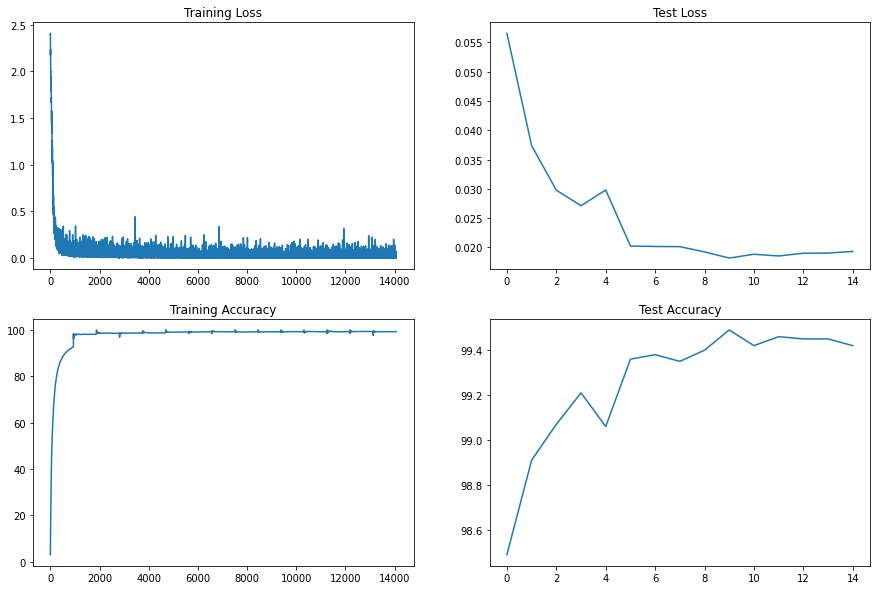

In [13]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")